In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def nearest_neighbor_interpolation(img, new_height, new_width):
    """
    Nearest Neighbor Interpolation
    Maps each pixel in output to nearest pixel in input
    """
    height, width, channels = img.shape
    emptyImage = np.zeros((new_height, new_width, channels), np.uint8)
    
    sh = new_height / height  # scale factor for height
    sw = new_width / width    # scale factor for width
    
    for i in range(new_height):
        for j in range(new_width):
            # Map output coordinates to input coordinates
            x = int(i / sh)
            y = int(j / sw)
            emptyImage[i, j] = img[x, y]
    
    return emptyImage

In [ ]:
def bilinear_interpolation(img, new_height, new_width):
    """
    Bilinear Interpolation
    Interpolates using weighted average of 4 nearest neighbors
    """
    height, width, channels = img.shape
    output = np.zeros((new_height, new_width, channels), np.uint8)
    
    sh = height / new_height  # scale factor for height
    sw = width / new_width    # scale factor for width
    
    for i in range(new_height):
        for j in range(new_width):
            # Map output coordinates to input coordinates (floating point)
            x = i * sh
            y = j * sw
            
            # Get integer parts (coordinates of top-left pixel)
            x1 = int(np.floor(x))
            y1 = int(np.floor(y))
            
            # Handle boundary conditions
            x2 = min(x1 + 1, height - 1)
            y2 = min(y1 + 1, width - 1)
            
            # Get fractional parts (for weighted interpolation)
            dx = x - x1
            dy = y - y1
            
            # Bilinear interpolation formula
            # f(x,y) = f(x1,y1)(1-dx)(1-dy) + f(x2,y1)(dx)(1-dy) + 
            #          f(x1,y2)(1-dx)(dy) + f(x2,y2)(dx)(dy)
            for c in range(channels):
                pixel = (img[x1, y1, c] * (1 - dx) * (1 - dy) +
                        img[x2, y1, c] * dx * (1 - dy) +
                        img[x1, y2, c] * (1 - dx) * dy +
                        img[x2, y2, c] * dx * dy)
                output[i, j, c] = np.clip(pixel, 0, 255)
    
    return output

In [ ]:
def cubic_weight(x):
    """
    Cubic convolution interpolation kernel (Catmull-Rom)
    Used for calculating weights in bicubic interpolation
    """
    x = abs(x)
    if x <= 1:
        return 1.5 * x**3 - 2.5 * x**2 + 1
    elif x < 2:
        return -0.5 * x**3 + 2.5 * x**2 - 4 * x + 2
    else:
        return 0

In [ ]:
def bicubic_interpolation(img, new_height, new_width):
    """
    Bicubic Interpolation
    Uses weighted average of 16 nearest neighbors (4x4 grid)
    Provides smoother results than bilinear
    """
    height, width, channels = img.shape
    output = np.zeros((new_height, new_width, channels), np.uint8)
    
    sh = height / new_height
    sw = width / new_width
    
    for i in range(new_height):
        for j in range(new_width):
            # Map output coordinates to input coordinates
            x = i * sh
            y = j * sw
            
            # Get integer part (center of 4x4 neighborhood)
            x0 = int(np.floor(x))
            y0 = int(np.floor(y))
            
            # Get fractional parts
            dx = x - x0
            dy = y - y0
            
            # For each color channel
            for c in range(channels):
                pixel_value = 0.0
                
                # Loop through 4x4 neighborhood
                for m in range(-1, 3):
                    for n in range(-1, 3):
                        # Calculate neighbor coordinates with boundary handling
                        xi = np.clip(x0 + m, 0, height - 1)
                        yi = np.clip(y0 + n, 0, width - 1)
                        
                        # Calculate weights using cubic kernel
                        weight_x = cubic_weight(m - dx)
                        weight_y = cubic_weight(n - dy)
                        weight = weight_x * weight_y
                        
                        # Accumulate weighted pixel values
                        pixel_value += img[xi, yi, c] * weight
                
                output[i, j, c] = np.clip(pixel_value, 0, 255)
    
    return output

Original image shape: (1024, 677, 3)

=== Part 1: Image Resizing with Interpolation ===
Applying Nearest Neighbor Interpolation...
Applying Bilinear Interpolation...
Applying Bicubic Interpolation...


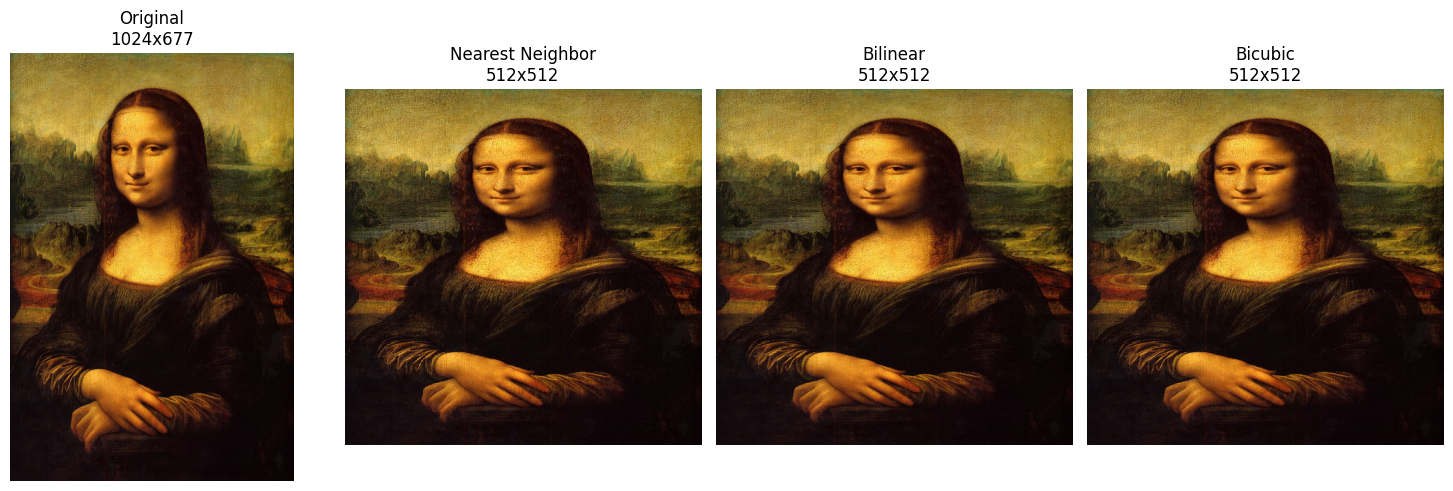

In [5]:
# Load image
img = cv2.imread("monalisa.jpg")

print("Original image shape:", img.shape)

# Part 1: Interpolation methods
print("\n=== Part 1: Image Resizing with Interpolation ===")
target_size = (512, 512)  # You can change this

print("Applying Nearest Neighbor Interpolation...")
nn_result = nearest_neighbor_interpolation(img, target_size[0], target_size[1])

print("Applying Bilinear Interpolation...")
bilinear_result = bilinear_interpolation(img, target_size[0], target_size[1])

print("Applying Bicubic Interpolation...")
bicubic_result = bicubic_interpolation(img, target_size[0], target_size[1])

# Display interpolation results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f'Original\n{img.shape[0]}x{img.shape[1]}')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(nn_result, cv2.COLOR_BGR2RGB))
plt.title(f'Nearest Neighbor\n{target_size[0]}x{target_size[1]}')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(bilinear_result, cv2.COLOR_BGR2RGB))
plt.title(f'Bilinear\n{target_size[0]}x{target_size[1]}')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(bicubic_result, cv2.COLOR_BGR2RGB))
plt.title(f'Bicubic\n{target_size[0]}x{target_size[1]}')
plt.axis('off')

plt.tight_layout()
plt.savefig('interpolation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
def create_translation_matrix(tx, ty):
    """Create translation matrix"""
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ], dtype=float)

In [ ]:
def create_scaling_matrix(sx, sy):
    """Create scaling matrix"""
    return np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ], dtype=float)

In [ ]:
def create_rotation_matrix(angle_degrees):
    """Create rotation matrix (counter-clockwise)"""
    theta = np.radians(angle_degrees)
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ], dtype=float)

In [ ]:
def create_shear_matrix(shx, shy):
    """Create shear matrix"""
    return np.array([
        [1, shx, 0],
        [shy, 1, 0],
        [0, 0, 1]
    ], dtype=float)

In [ ]:
def apply_affine_transform(img, transform_matrix, interpolation='bilinear'):
    """
    Apply affine transformation to image
    Uses inverse mapping to avoid holes in output
    """
    height, width, channels = img.shape
    
    # Calculate output image dimensions by transforming corners
    corners = np.array([
        [0, 0, 1],
        [width-1, 0, 1],
        [0, height-1, 1],
        [width-1, height-1, 1]
    ]).T
    
    transformed_corners = transform_matrix @ corners
    
    # Calculate bounding box
    min_x = int(np.floor(np.min(transformed_corners[0, :])))
    max_x = int(np.ceil(np.max(transformed_corners[0, :])))
    min_y = int(np.floor(np.min(transformed_corners[1, :])))
    max_y = int(np.ceil(np.max(transformed_corners[1, :])))
    
    out_width = max_x - min_x + 1
    out_height = max_y - min_y + 1
    
    output = np.zeros((out_height, out_width, channels), np.uint8)
    
    # Compute inverse transformation matrix
    try:
        inverse_matrix = np.linalg.inv(transform_matrix)
    except:
        print("Matrix is not invertible")
        return img
    
    # Apply inverse mapping
    for i in range(out_height):
        for j in range(out_width):
            # Output coordinates (adjusted for bounding box)
            out_coords = np.array([j + min_x, i + min_y, 1])
            
            # Map to input coordinates
            in_coords = inverse_matrix @ out_coords
            x, y = in_coords[0], in_coords[1]
            
            # Check if within bounds
            if 0 <= x < width-1 and 0 <= y < height-1:
                if interpolation == 'nearest':
                    output[i, j] = img[int(y), int(x)]
                elif interpolation == 'bilinear':
                    # Bilinear interpolation
                    x1, y1 = int(np.floor(x)), int(np.floor(y))
                    x2, y2 = min(x1 + 1, width - 1), min(y1 + 1, height - 1)
                    dx, dy = x - x1, y - y1
                    
                    for c in range(channels):
                        pixel = (img[y1, x1, c] * (1-dx) * (1-dy) +
                                img[y1, x2, c] * dx * (1-dy) +
                                img[y2, x1, c] * (1-dx) * dy +
                                img[y2, x2, c] * dx * dy)
                        output[i, j, c] = np.clip(pixel, 0, 255)
    
    return output


=== Part 2: Affine Transformations ===
Applying Scaling...
Applying Rotation...
Applying Translation...
Applying Shearing...


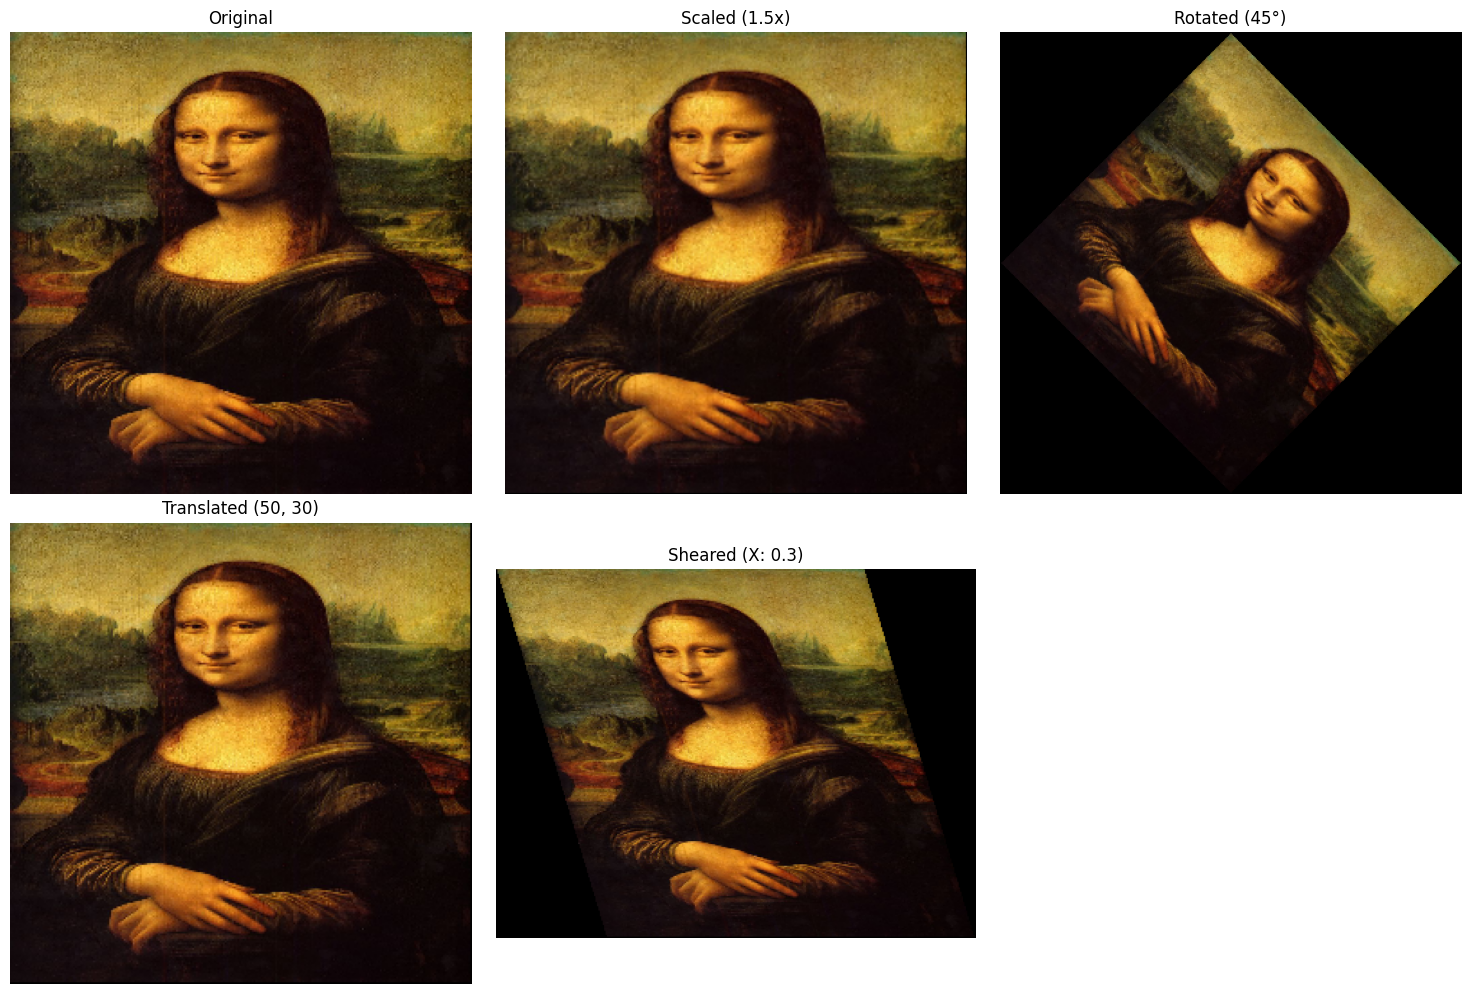


=== Processing Complete ===
Results saved as 'interpolation_comparison.png' and 'affine_transformations.png'


In [6]:
# Part 2: Affine Transformations
print("\n=== Part 2: Affine Transformations ===")

# Resize image for faster processing
small_img = cv2.resize(img, (256, 256))
h, w = small_img.shape[:2]

# 1. Scaling
print("Applying Scaling...")
scale_matrix = create_scaling_matrix(1.5, 1.5)
scaled = apply_affine_transform(small_img, scale_matrix)

# 2. Rotation
print("Applying Rotation...")
# Rotate around center
cx, cy = w // 2, h // 2
rotation_matrix = (create_translation_matrix(cx, cy) @ 
                    create_rotation_matrix(45) @ 
                    create_translation_matrix(-cx, -cy))
rotated = apply_affine_transform(small_img, rotation_matrix)

# 3. Translation
print("Applying Translation...")
translation_matrix = create_translation_matrix(50, 30)
translated = apply_affine_transform(small_img, translation_matrix)

# 4. Shearing
print("Applying Shearing...")
shear_matrix = create_shear_matrix(0.3, 0.0)
sheared = apply_affine_transform(small_img, shear_matrix)

# Display affine transformation results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB))
plt.title('Scaled (1.5x)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.title('Rotated (45°)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(translated, cv2.COLOR_BGR2RGB))
plt.title('Translated (50, 30)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(sheared, cv2.COLOR_BGR2RGB))
plt.title('Sheared (X: 0.3)')
plt.axis('off')

plt.tight_layout()
plt.savefig('affine_transformations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Processing Complete ===")
print("Results saved as 'interpolation_comparison.png' and 'affine_transformations.png'")